# 挖掘出模型

In [2]:
import os
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

import pandas as pd
import numpy as np
# import pm4py

In [3]:
# bpi2013="log/BPI_Challenge_2013_open_problems.xes"#模型太小
# cc19="log/CCC19.xes"
# review="log/review_example_large.xes"
# sepsis="log/Sepsis_Cases.xes"
# hos="log/hospital_log.xes"
bpi12="log/BPI_Challenge_2012.xes"

In [4]:
log = xes_importer.apply(os.path.join(bpi12))

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [5]:
len(log)

13087

In [6]:
net, initial_marking, final_marking = inductive_miner.apply(log)

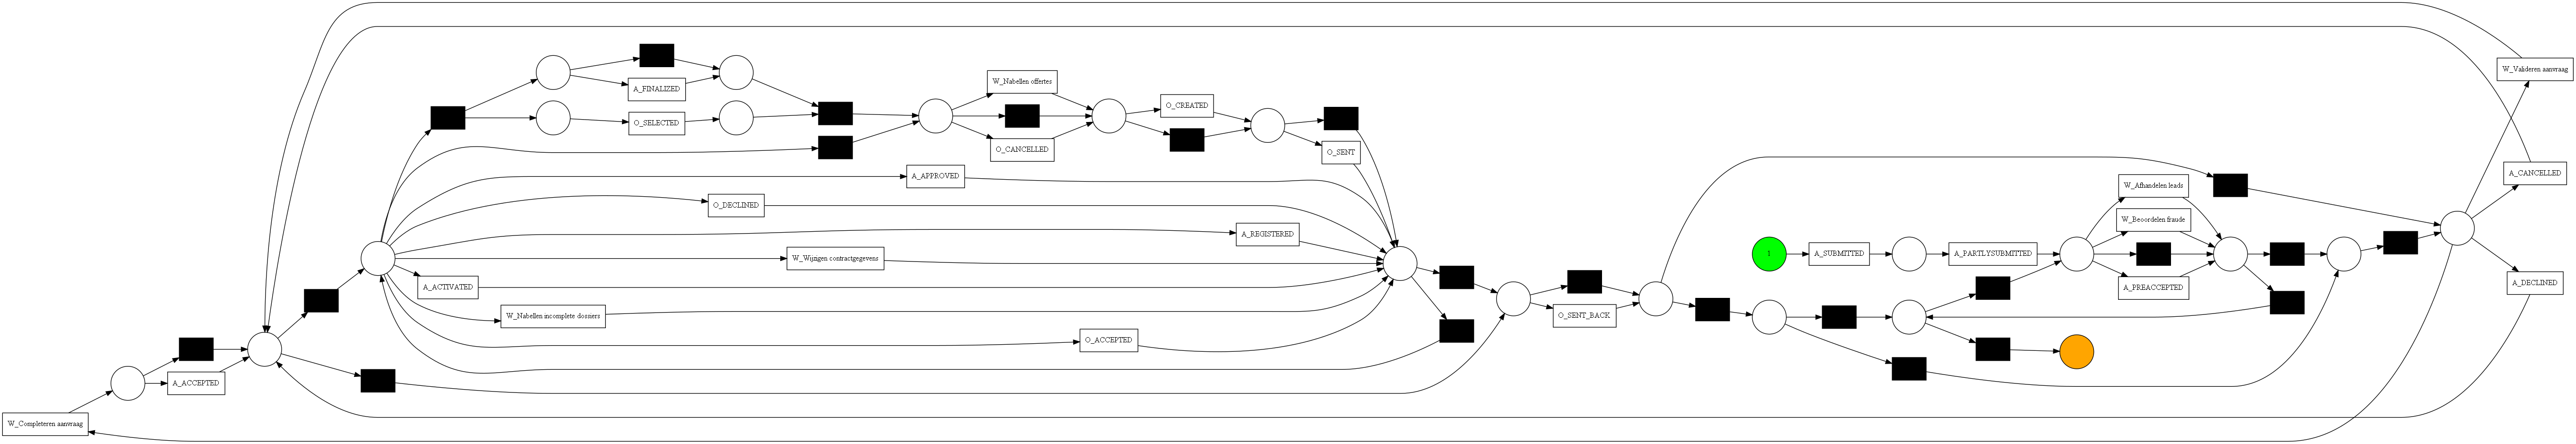

In [7]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [8]:
 simplicity_evaluator.apply(net)

0.5609756097560976

In [9]:
list_all=[]
def pri_easy_trace(log_trace):
    listname = []
    for i in range(0,len(log_trace)):
        result = str(log_trace[i]).split("name': '", 1)
        result = result[1].split("'", 1)
        listname.append(str(result[0]))
#     print(listname)
    list_all.append(listname)
#     return listname
#打印出所有仿真出来的迹
def pri_all_easy_trace(log_s):
    for i in range(0,len(log_s)):
        pri_easy_trace(log_s[i])

In [10]:
# pri_easy_trace(log[0])

In [11]:
pri_all_easy_trace(log)

# 聚类

In [12]:
from matplotlib import pyplot  as plt
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

In [13]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris,load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

In [14]:
cc=np.load("data.npy")

In [15]:
from collections import Counter

# 聚类后转csv

In [21]:
list_tm=np.array(list_all)

<ipython-input-21-dc355fcf2910>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_tm=np.array(list_all)


In [22]:
def save_csv(list_true,name):
    cc=[]
    dd=[]
    for i in range(0,len(list_true)):
#         print(i)
#         print(list_true[i])
        for j in list_true[i]:
            cc.append(j)
            dd.append(i)
    ee=[]
    ee.append(cc)
    ee.append(dd)
    names=['concept:name','case:concept:name']
    df = pd.DataFrame(data=ee,index=names)
    df=df.T
    df["time:timestamp"]=[str(pd.Timestamp("1970/4/27  1:46:41")+pd.Timedelta('1s')*x) for x in range(0,df.shape[0])]
    df=df.loc[:,['concept:name','time:timestamp','case:concept:name']]
    df.to_csv(name+".csv")
def save_cluser(method_name,labels_):
    list0=list_tm[np.where(labels_==0)[0]]
    list1=list_tm[np.where(labels_==1)[0]]
    list2=list_tm[np.where(labels_==2)[0]]
    list0=list0.tolist()
    list1=list1.tolist()
    list2=list2.tolist()
    save_csv(list0,"clust0"+str(method_name))
    save_csv(list1,"clust1"+str(method_name))
    save_csv(list2,"clust2"+str(method_name))

# KMeans划分聚类

In [23]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3).fit(cc)

In [24]:
count = Counter(km.labels_)

In [25]:
count

Counter({0: 3998, 2: 2012, 1: 7077})

In [26]:
save_cluser("KMeans",km.labels_)

# Birch聚类

In [27]:
from sklearn.cluster import Birch
gas= Birch(n_clusters=3).fit(cc)
count = Counter(gas.labels_)
count

Counter({0: 11313, 2: 572, 1: 1202})

In [28]:
save_cluser("Birch",gas.labels_)

# MiniBatchKMeans

In [29]:
from sklearn.cluster import  MiniBatchKMeans
clustering = MiniBatchKMeans(n_clusters=3).fit(cc)

D:\ancod3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [30]:
count = Counter(clustering.labels_)
count

Counter({0: 4367, 2: 1494, 1: 7226})

In [31]:
save_cluser("MiniBatchKMeans",clustering.labels_)

# 使用官方代码保存为csv格式

In [32]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

In [36]:
clu_name=["Birch","KMeans","MiniBatchKMeans"]

In [44]:
from numpy import mean

In [45]:
for i in clu_name:
    list_av=[]
    for j in range(3):
        datename="clust"+str(j)+i+".csv"
        log_csv = pd.read_csv(datename, sep=',')
        log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
        log_csv = log_csv.sort_values('time:timestamp')
        event_log = log_converter.apply(log_csv)
        net, initial_marking, final_marking = inductive_miner.apply(event_log)
#         simplicity_evaluator.apply(net)
        list_av.append(simplicity_evaluator.apply(net))
    print(mean(list_av))


0.6179309311839432
0.6036749928222797
0.6046828033538997


In [7]:
log_csv = pd.read_csv("clust2.csv", sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
log_csv = log_csv.sort_values('time:timestamp')
event_log = log_converter.apply(log_csv)

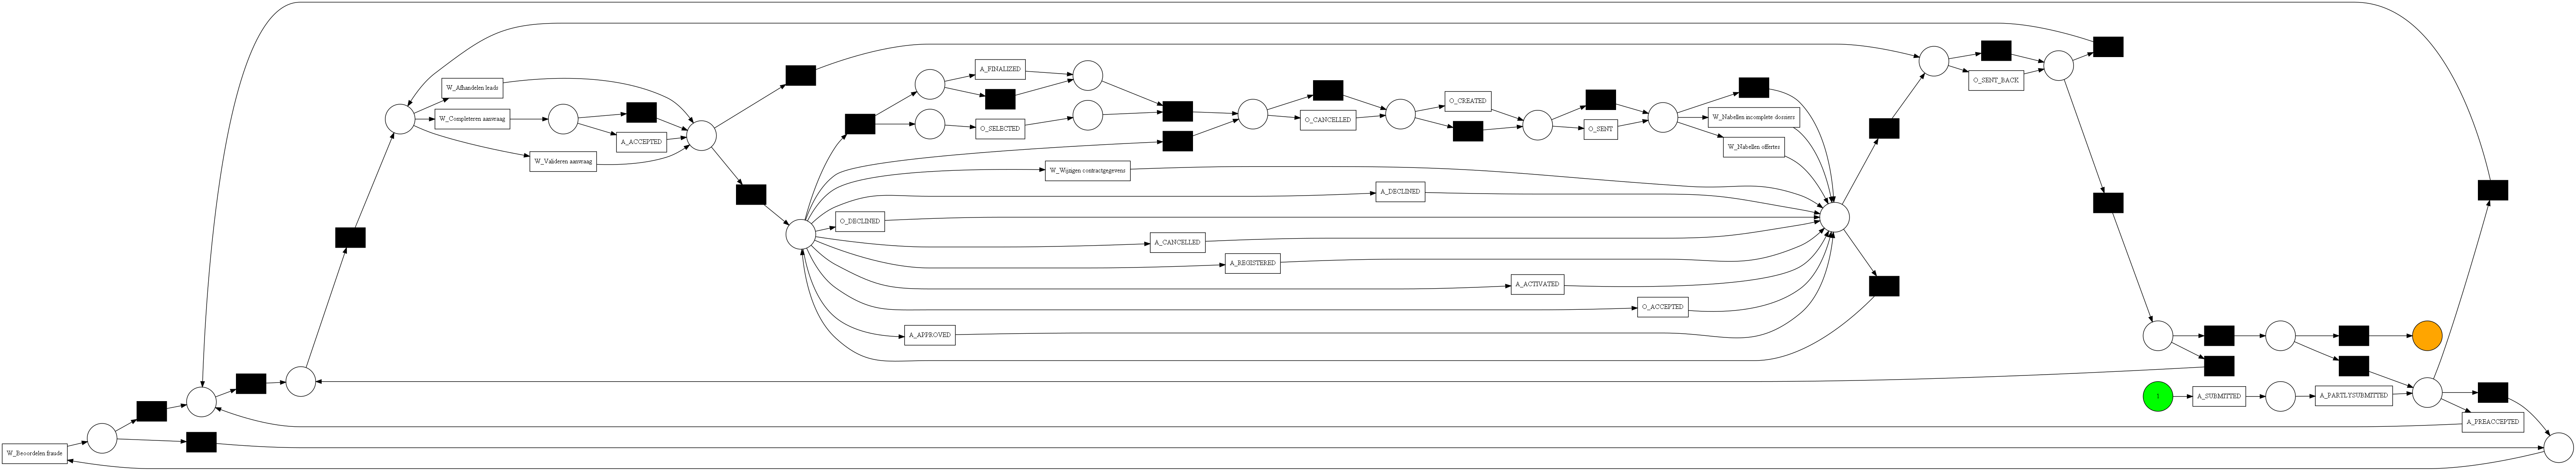

0.5813953488372092

In [8]:
net, initial_marking, final_marking = inductive_miner.apply(event_log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)
simplicity_evaluator.apply(net)